In [ ]:
#Imort the required libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import random
import copy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])
          

In [ ]:
#Loading the data

#Training set
train_set = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,shuffle=True, num_workers=2)
# Testing set
test_set = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128,shuffle=False, num_workers=2)

In [ ]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print(len(train_loader))
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])
469


In [ ]:
# Define the CNN
class LeNet(nn.Module):
  def __init__(self, num_class=10):
    super(LeNet, self).__init__()
    self.features  = nn.Sequential(
        nn.Conv2d(1, 6, 5), 
        nn.ReLU(),
        nn.MaxPool2d(2), 
        nn.Conv2d(6, 16, 5),
        nn.ReLU(), 
        nn.MaxPool2d(2))
    
    self.classifier = nn.Sequential(
        nn.Linear(256, 120), 
        nn.ReLU(), 
        nn.Linear(120, 84), 
        nn.ReLU(), 
        nn.Linear(84, num_class))
    
  def forward(self,x):
    x = self.features(x)
    x = x.view(x.size(0), -1) 
    x = self.classifier(x)
    return x

In [ ]:
from torch.optim import Optimizer
import copy


class Katyusha_k(Optimizer):
    """Optimizer for calculating the gradient step in the inner loop of the algorithm
    Args:
        params (iterable): Network parameters
        lips : Lipschitz constant
        m : No of iterations to be performed in the inner loop    
    """
    def __init__(self, params, lips = 10, m = 500):
        if lips < 0.0:
            raise ValueError("Invalid lipschitz constant : {}".format(lips))
        if m < 0.0:
            raise ValueError("Invalid frequency value: {}".format(m))
        self.x_tilda = None
        self.tau_2 = 0.5
        self.counter = 0
        self.lips = lips
        self.m = m    
        defaults = dict(lips=lips, m=m)
        super(Katyusha_k, self).__init__(params, defaults)
    
    def get_param_groups(self):
            return self.avg_y

    def set_outparam(self, new_param):
        """ Set the out parameter for the epoch
        """
        self.tau_1 = 2/(self.counter+4)
        self.counter += 1
        self.alpha = 1/(3*self.tau_1*self.lips) 
        if self.x_tilda is None:
            self.x_k = copy.deepcopy(new_param)
            self.y_k = copy.deepcopy(new_param)
            self.z_k = copy.deepcopy(new_param)
            self.avg_y = copy.deepcopy(new_param)
        self.x_tilda = copy.deepcopy(new_param)
        for xtil_group, new_group in zip(self.x_tilda, new_param):  
            for xtil, new_u in zip(xtil_group['params'], new_group['params']):
                xtil.grad = new_u.grad.clone()
        for avg_grp, param in zip(self.avg_y,self.y_k):
          for avg, par in zip(avg_grp['params'],param['params']):
            avg.data = torch.zeros_like(par.data)        

    def compute_xk(self):
        for x,y,z,x_tilda in zip(self.param_groups,self.y_k,self.z_k,self.x_tilda):
            for xk,yk,zk,xtil in zip(x['params'],y['params'],z['params'],x_tilda['params']):
                xk.data = (self.tau_1*zk.data) + (self.tau_2*xtil.data) + ((1-self.tau_1-self.tau_2)*yk.data)
            

    def step(self, params):
        """Performs a single optimization step.
        """
        for group, new_group, xtilda_group, yk, zk, avg in zip(self.param_groups, params, self.x_tilda, self.y_k, self.z_k, self.avg_y):
            for p, q, u, y, z, av in zip(group['params'], new_group['params'], xtilda_group['params'], yk['params'], zk['params'], avg['params']):
                if p.grad is None:
                    continue
                if q.grad is None:
                    continue
                # Katyusha gradient update 
                new_d = p.grad.data - q.grad.data + u.grad.data
                y.data = p.data - (1/(3*self.lips))*new_d
                z.data = z.data - (self.alpha*new_d)
                av.data = av.data + (1/self.m)*y.data


class Katyusha_Snapshot(Optimizer):
    """Optimizer for calculating the mean gradient w.r.t snapshot parameters (snapshot)
    Args:
        params (iterable): Network parameters
    """
    def __init__(self, params):
        defaults = dict()
        super(Katyusha_Snapshot, self).__init__(params, defaults)
      
    def get_param_groups(self):
            return self.param_groups
    
    def set_param_groups(self, new_parameters):
        """Copies the parameters from Katyusha_k optimizer. 
        """
        for group, new_group in zip(self.param_groups, new_parameters): 
            for p, q in zip(group['params'], new_group['params']):
                  p.data[:] = q.data[:]

In [ ]:
net_snap = LeNet()
net_step = LeNet()

In [ ]:
net_step.load_state_dict(net_snap.state_dict())

<All keys matched successfully>

In [ ]:
net_snap.to(device)

LeNet(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
net_step.to(device)

LeNet(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer_snap = Katyusha_Snapshot(net_snap.parameters())
optimizer_step = Katyusha_k(net_step.parameters())

In [ ]:
train_loss = []
accuracy_list = []
for epoch in range(30):
    
    running_loss = 0
    optimizer_snap.zero_grad() 
    for i, data in enumerate(train_loader, 0):
    # Get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)
    # Zero the parameter gradients
        outputs = net_snap(inputs)
        loss = criterion(outputs, labels) / len(train_loader)
        loss.backward()
        running_loss += loss.item()
    train_loss.append(running_loss)
    p = optimizer_snap.get_param_groups()
    optimizer_step.set_outparam(p)
    for i in range(500):
        optimizer_step.compute_xk()
        data = next(iter(train_loader))
        inp, lab = data[0].to(device), data[1].to(device)
        out_step = net_step(inp)
        l_step = criterion(out_step, lab)
        optimizer_step.zero_grad()
        l_step.backward()

        out_snap = net_snap(inp)
        l_snap = criterion(out_snap, lab)
        optimizer_snap.zero_grad()
        l_snap.backward()
        optimizer_step.step(optimizer_snap.get_param_groups())
    optimizer_snap.set_param_groups(optimizer_step.get_param_groups())
    
    
    correct = 0
    total = 0
    net_snap.eval()
    for i, data in enumerate(test_loader, 0):
        images, label = data[0].to(device),data[1].to(device)
        output = net_snap(images)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    print('Iteration: {}  Train_Loss: {}  Accuracy: {} %'.format(epoch, running_loss, accuracy))    
        
        

Iteration: 0  Train_Loss: 2.3070016857236624  Accuracy: 86.33 %
Iteration: 1  Train_Loss: 1.069487128406763  Accuracy: 95.05 %
Iteration: 2  Train_Loss: 0.17052728433918674  Accuracy: 97.4 %
Iteration: 3  Train_Loss: 0.08771049025381217  Accuracy: 97.99 %
Iteration: 4  Train_Loss: 0.058558278524287743  Accuracy: 98.38 %
Iteration: 5  Train_Loss: 0.04148895116759377  Accuracy: 98.53 %
Iteration: 6  Train_Loss: 0.030184540916252445  Accuracy: 98.7 %
Iteration: 7  Train_Loss: 0.02213365389388855  Accuracy: 98.56 %
Iteration: 8  Train_Loss: 0.027587656298464935  Accuracy: 98.52 %
Iteration: 9  Train_Loss: 0.03267874855919217  Accuracy: 98.77 %
Iteration: 10  Train_Loss: 0.02027785126983872  Accuracy: 98.94 %
Iteration: 11  Train_Loss: 0.013544244871923183  Accuracy: 98.89 %
Iteration: 12  Train_Loss: 0.009309507599027711  Accuracy: 98.97 %
Iteration: 13  Train_Loss: 0.006408879584029137  Accuracy: 99.0 %
Iteration: 14  Train_Loss: 0.0042141068069270204  Accuracy: 98.97 %
Iteration: 15  Tra

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training Loss on MNIST')

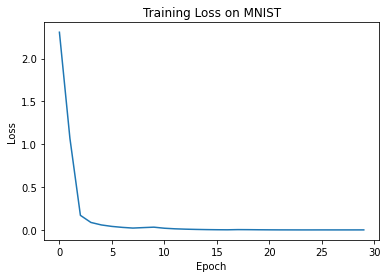

In [ ]:
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss on MNIST')

Text(0.5, 1.0, 'Accuracy on MNIST test data')

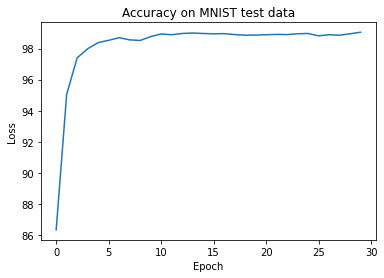

In [ ]:
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy on MNIST test data')